# Task

Select a set $S = { S_1, S_2, …, S_n }$ of sequences of events from the set $E$:
* the size of set E has to be at least 10: $\#{E} \ge 10$,
* the average length of sequences > 5: $E[len(S_i)] > 5$,
* $n > 200$. 

For example: $S$ are the sentences from some book (project Gutenberg), events are letters in the sentences - $E$ is the alphabet extended with punctuation marks and space.

Construct a transition matrix of a Markov chain summarizing selected set S. Consider two options: you start counting with
* all entries set to 0
* all entries set to 1
Starting with 1 is beneficial because we won't have zero's.

Define a value $v(S)$ of a sequence $S = e_1,e_2,…,e_k$ as a geometric mean of probabilities of the corresponding transitions

$v(S) = ( p(e_1,e_2) \times p(e_2,e_3) \times p(e_3,e_4) \times … \times p(e_{k-1},e_k) )^{1/(k-1)}$

$v(S)$ is a multiplication of probabilities. A large value of v(S) means S is specific for that Markov chain.

Compute the distribution of values $v(S)$ for all sequences from $S$. Compare it with (a distribution of) values of some other sequences - for example another book in some other language.

# Data

I like the idea about books. So, I chose four books for the task:

1. Wuthering Heights by Emily Bronte [link](http://www.gutenberg.org/ebooks/768). It's in English with some rare and some words.
2. Odes and Epodes by Horace [link](http://www.gutenberg.org/ebooks/9646)

I was interested a bit into comparing an 'old' English with the relatively 'modern' English. For that reason, I also compared the distribution for the books

3. Romeo and Juliet by William Shakespeare [link](http://www.gutenberg.org/ebooks/2261)

All words in the book were converted to the lower case before processing.

# Initialization

In [14]:
sequence_sets = {0: {'name':         'Wuthering Heights by Emily Bronte',
                     'file_name':    'data/768.txt.zip',
                     'start_marker': 'WUTHERING HEIGHTS.+?CHAPTER I',
                     'end_marker':   '\*\*\*END OF THE PROJECT GUTENBERG EBOOK.+?\*\*\*' },
                 1: {'name':         'Romeo and Juliet by William Shakespeare (Old English)',
                     'file_name':    'data/pg2261.txt.zip',
                     'start_marker': 'The Tragedie of Romeo and Juliet.+?Actus Primus. Scoena Prima.',
                     'end_marker':   'FINIS. THE TRAGEDIE OF ROMEO and IVLIET'},
                 2: {'name':         'Odes and Epodes by Horace (Latin)',
                     'file_name':    'data/pg9646.txt.zip',
                     'start_marker': 'Q. HORATII FLACCI',
                     'end_marker':   'End of the Project Gutenberg EBook of Odes and Epodes, by Horace'}}

# dictionary of models built for the sequence sets
models = {}

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging

import sys

import numpy as np
import pandas as pd

pd.set_option('display.max_rows',    100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import statsmodels.api as sm

logger = logging.getLogger('main')

if (logger.hasHandlers()):
    logger.handlers.clear()

logger.addHandler(logging.StreamHandler(sys.stdout))
logger.handlers[-1].setFormatter(logging.Formatter(fmt='%(asctime)s - %(levelname)s - %(message)s', 
                                                   datefmt='%Y-%m-%d %H:%M:%S'))

logger.setLevel(logging.DEBUG)

# Build Models

In [16]:
import mc_gmean_model
#from importlib import reload 
#reload(mc_gmean_model)

In [17]:
# masking function: True - valid sequences, False - not valid sequence
def seq_mask(s):
    return(s.isalpha() and len(s) >=2 )

# transformation of sequence
def seq_transform(s):
    return(s.lower())

for seq_set_no, v in sequence_sets.items():
    
    #if seq_set_no > 0:
    #    continue
        
    print('Processing the set ''%s''' % v['name'])

    models[seq_set_no] = mc_gmean_model.mc_gmean_model()

    # getting sequences from a file
    file_name = v['file_name']
    t = mc_gmean_model.text_file_tokenizer(file_name)
    seqs = t.tokenize(v['start_marker'], v['end_marker'], mask_fn = seq_mask, transform_fn = seq_transform)
    
    models[seq_set_no].transition_matrix(sequences = seqs)
    #models[seq_set_no].compute_seqs()
    models[seq_set_no].compute_seqs(tm = models[0].tm)
    models[seq_set_no].describe()
    
    print()

Processing the set Wuthering Heights by Emily Bronte
2018-06-24 21:39:27 - DEBUG - Read the textual information of the length 681636
2018-06-24 21:39:27 - DEBUG - The length after taking the part between the markers: 661838
The number of sequences: 9025
The minimal length:      2.00
The maximum length:      18.00
The average length:      7.15

Processing the set Romeo and Juliet by William Shakespeare (Old English)
2018-06-24 21:39:36 - DEBUG - Read the textual information of the length 156143
2018-06-24 21:39:36 - DEBUG - The length after taking the part between the markers: 139770


c:\python36\lib\site-packages\scipy\stats\stats.py:305: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


The number of sequences: 3754
The minimal length:      2.00
The maximum length:      16.00
The average length:      6.16

Processing the set Odes and Epodes by Horace (Latin)
2018-06-24 21:39:39 - DEBUG - Read the textual information of the length 168845
2018-06-24 21:39:39 - DEBUG - The length after taking the part between the markers: 148761
The number of sequences: 8234
The minimal length:      2.00
The maximum length:      16.00
The average length:      6.87



In [18]:
models[0].tm

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,0.000057,0.021773,0.030551,0.050073,0.000228,0.010317,0.017726,0.002508,0.047280,0.000114,0.016928,0.060532,0.023369,0.241301,0.000057,0.017954,0.000000,0.105161,0.107299,0.160763,0.012141,0.031605,0.012511,0.000712,0.027331,0.001710
b,0.057147,0.009095,0.000000,0.001516,0.373200,0.000000,0.000000,0.000606,0.034106,0.009550,0.000000,0.124451,0.000152,0.000000,0.099742,0.000000,0.000000,0.069425,0.025466,0.008337,0.115204,0.001516,0.000152,0.000000,0.070335,0.000000
c,0.145895,0.000000,0.017241,0.000175,0.166988,0.000000,0.000000,0.148083,0.030719,0.000000,0.056975,0.077017,0.000000,0.000000,0.208122,0.000000,0.002626,0.040959,0.000438,0.068178,0.030807,0.000000,0.000000,0.000000,0.005776,0.000000
d,0.060360,0.000000,0.000133,0.025849,0.307395,0.002398,0.025583,0.000533,0.186676,0.000533,0.000666,0.046902,0.004530,0.007328,0.156429,0.000000,0.000000,0.051566,0.050233,0.000533,0.030247,0.006396,0.001199,0.000000,0.034510,0.000000
e,0.095896,0.001062,0.026048,0.161251,0.042393,0.012888,0.007061,0.003432,0.016518,0.000543,0.003383,0.054220,0.025554,0.112834,0.001531,0.023184,0.002247,0.224779,0.076441,0.045035,0.000346,0.023061,0.007728,0.015555,0.016691,0.000321
f,0.105951,0.000000,0.000000,0.000000,0.117674,0.131350,0.000000,0.000000,0.109558,0.000000,0.000000,0.039525,0.000000,0.000150,0.247220,0.000000,0.000000,0.120679,0.001353,0.062369,0.062218,0.000000,0.000000,0.000000,0.001954,0.000000
g,0.123725,0.000165,0.000000,0.000329,0.190194,0.000000,0.014972,0.235604,0.066469,0.000000,0.000000,0.049687,0.001810,0.019414,0.106120,0.000165,0.000000,0.108424,0.028299,0.007404,0.044587,0.000000,0.000000,0.000000,0.002632,0.000000
h,0.174744,0.000939,0.016828,0.000174,0.511856,0.000522,0.000000,0.000070,0.149885,0.000000,0.000000,0.001738,0.001321,0.000730,0.074821,0.000000,0.000000,0.011195,0.002121,0.033273,0.010987,0.000000,0.000278,0.000000,0.008518,0.000000
i,0.007225,0.006119,0.026851,0.046965,0.037071,0.037234,0.030106,0.000260,0.000683,0.000000,0.007356,0.051587,0.057055,0.316225,0.043255,0.005175,0.000098,0.036550,0.136404,0.129373,0.000456,0.020570,0.000033,0.002083,0.000000,0.001269
j,0.061338,0.000000,0.000000,0.000000,0.206320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.436803,0.000000,0.000000,0.000000,0.000000,0.000000,0.295539,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
models[0].seqs.head(10)

,count,length,prob_gmean
have,620,4,0.158984
just,75,4,0.193792
returned,62,8,0.090603
from,484,4,0.092427
visit,26,5,0.123638
to,3472,2,0.176537
my,1076,2,0.119575
landlord,8,8,0.098885
the,4530,3,0.455113
solitary,6,8,0.068013


# Graph Visualization

Below, it's an effort to visualize the transition matrix for the primary set.

Name: Graph from pandas adjacency matrix
Type: Graph
Number of nodes: 26
Number of edges: 262
Average degree:  20.1538


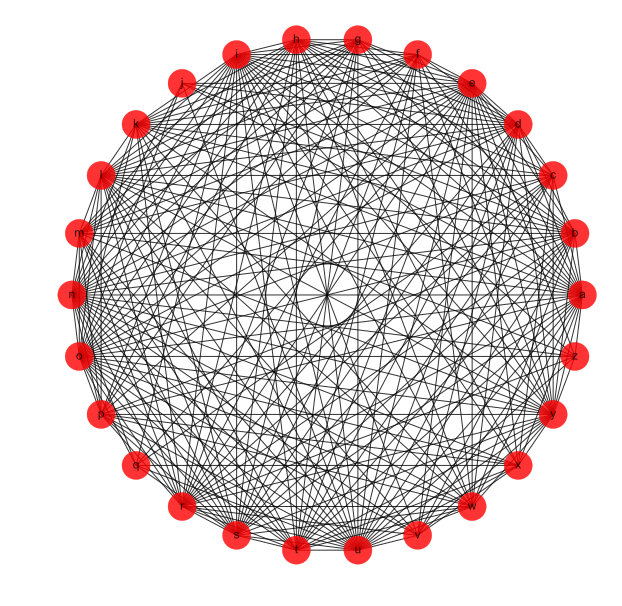

In [20]:
import networkx as nx

G = nx.from_pandas_adjacency(models[0].tm)
G.name = 'Graph from pandas adjacency matrix'
print(nx.info(G))

plt.figure(figsize=(8, 8))
nx.draw_shell(G, with_labels = True, node_size = 800, alpha = 0.8, arrows = True)

# Compare Distributions

## Visualization of Transition Matrices

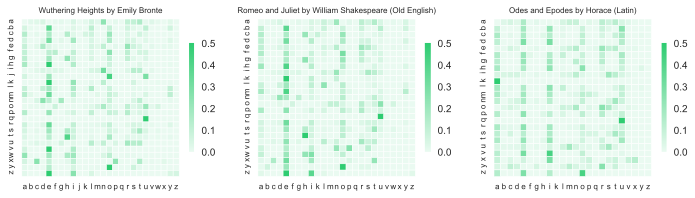

In [21]:
# plot correlation matrix
plt.style.use('seaborn-white')

fig, axs = plt.subplots(figsize=(12, 4), nrows = 1, ncols = 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axs_flatten = axs.flatten()

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

cmap = sns.light_palette("#2ecc71", as_cmap=True)

for model_no, model in models.items():
    
    plt.sca(axs_flatten[model_no])
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(model.tm, 
                # annot = True, annot_kws={"size": 9}, fmt = '.2f',
                cmap=cmap, vmin = 0, vmax= 0.5, # center=0.5,
                square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, ax = axs_flatten[model_no])
    axs_flatten[model_no].set_title('%s' % sequence_sets[model_no]['name'], size = 8)
    
    plt.xticks(np.arange(0, len(model.tm.columns)) + 0.5, model.tm.columns, size = 8)  
    plt.yticks(np.arange(0, len(model.tm.index)) + 0.5,   model.tm.index,   size = 8)

plt.show()

plt.style.use('seaborn')

## Kernel Density Estimation

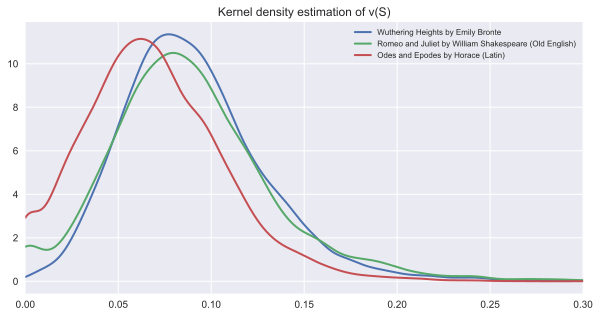

In [22]:
fig, axs = plt.subplots(figsize = (10, 5), ncols=1)

################################################################################
# draw kernel distribuion estimation of v(S)
################################################################################

# plt.sca(axs[1])

for model_no, model in models.items():
    
    kde = sm.nonparametric.KDEUnivariate(model.seqs['prob_gmean'])
    
    # kde.fit(kernel = 'epa', fft = False)
    kde.fit() # gaussian kernel with fft
    
    plt.plot(kde.support, kde.density, lw = 2, label = sequence_sets[model_no]['name'])

plt.xlim(0, 0.3)    
    
plt.title('Kernel density estimation of v(S)')
plt.legend(fontsize = 8)

plt.show()

# References
1. [The projects' descriptions on Vlado's site](http://vladowiki.fmf.uni-lj.si/doku.php?id=ru:hse:snet:stu)